In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
from sklearn.datasets import fetch_openml

### Data Prepare Class :

In [2]:
class DataPrepare(object):
    def __init__(self, dataset, test_split=0, batch_size=0, validation_split=.0, shuffle=False):
        self.num_samples = dataset[0].shape[0]
        dsIndx = np.arange(self.num_samples)
        if shuffle:
            np.random.shuffle(dsIndx)
        self.dataset = dataset[0][dsIndx], dataset[1][dsIndx]
        self.num_valid = int(self.num_samples * validation_split)
        self.num_test  = int(self.num_samples * test_split)
        self.num_train = self.num_samples - self.num_test - self.num_valid
        if batch_size == 0:
            self.batch_size = self.num_samples
            self.num_batchs = 1
        else:
            self.batch_size = batch_size   
            self.num_batchs = self.num_train // batch_size
            if self.num_train % batch_size != 0:
                self.num_batchs += 1 
        if self.num_valid:
            self.validations = self.dataset[0][self.num_train:self.num_train+self.num_valid], self.dataset[1][self.num_train:self.num_train+self.num_valid]
        else:
            self.validations = 0
        if self.num_test:
            self.test = self.dataset[0][self.num_train+self.num_valid::], self.dataset[1][self.num_train+self.num_valid::]
        self.train = self.dataset[0][0:self.num_train], self.dataset[1][0:self.num_train]

            
    def __iter__(self):
        for i in range(0, self.num_train, self.batch_size):
            yield (self.train[0][i:i+self.batch_size], self.train[1][i:i+self.batch_size]) 
            
    def __len__(self):
        return self.num_batchs
    
    def info(self):
        print('Number of Samples: {} (# Batchs : {})\n | # Train: {} | # Validation: {} | # Test: {}'.format
             (self.num_samples, self.num_batchs, self.num_train, self.num_valid, self.num_test))

### Layers Classes :

In [3]:
class ReLU:
    def forward (self, x):
        self.old_x = x.copy()
        return np.clip(self.old_x, 0, None)
    def backward(self, grad):
        return np.where(self.old_x > 0, grad,0)

class Sigmoid:
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    def backward(self, grad):
        return self.y*(1 - self.y)*grad

class Softmax:
    def forward(self, x):
        n_exp = np.exp(x - x.max())
        self.y = n_exp / np.sum(n_exp, axis=1, keepdims=True)
        return self.y
    def backward(self, grad):
        return self.y*(grad - np.sum(grad*self.y, axis=1, keepdims=True))
    
class Dropout:
    def __init__(self, keep_prob):
        self.p = keep_prob
    def forward(self, x):
#         self.dropout = np.random.rand(x.shape[0], x.shape[1]) < self.p
        self.dropout = np.random.binomial(1, self.p, size=(x.shape[0], x.shape[1]))
        return np.multiply(x, self.dropout) / self.p
    def backward(self, grad):
        return np.multiply(grad, self.dropout) 
    
class BatchNormalization:
    def __init__(self, num_input):
        self.gamma = np.ones(num_input)
        self.beta = np.zeros(num_input)
    def forward(self, x):
        mu = np.mean(x, axis=0)
        var = np.var(x, axis=0)
        x_norm = (x - mu) / np.sqrt(var + 1e-8)
        out = self.gamma * x_norm + self.beta
        self.cache = (x, x_norm, mu, var)
        return out
    def backward(self, grad):
        x, x_norm, mu, var = self.cache
        N, D = x.shape
        x_mu = x - mu
        std_inv = 1. / np.sqrt(var + 1e-8)
        dx_norm = grad * self.gamma
        dvar = np.sum(dx_norm * x_mu, axis=0) * -.5 * std_inv**3
        dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2. * x_mu, axis=0)
        dx = (dx_norm * std_inv) + (dvar * 2 * x_mu / N) + (dmu / N)
        self.grad_gamma = np.sum(grad * x_norm, axis=0)
        self.grad_beta = np.sum(grad, axis=0)
        return dx

class Linear:
    def __init__(self, num_input, num_output):
        self.weights = np.random.randn(num_input, num_output)*np.sqrt(2 / num_input)
        self.biases = np.zeros((1, num_output))
    def forward(self, x):
        self.old_x = x.copy()
        return np.dot(x, self.weights) + self.biases
    def backward(self, grad):
#         self.grad_w = (np.matmul(self.old_x[:,:,None], grad[:,None,:])).mean(axis=0)
        self.grad_w = np.dot(self.old_x.T, grad) / self.old_x.shape[0]
        self.grad_b = grad.mean(axis=0)
#         self.grad_b = np.sum(grad, axis=0, keepdims=True)
        return np.dot(grad, self.weights.T)

### Loss Classes :

In [24]:
class Binary_CrossEntropy:
    def forward(self, y_hat, y):
        self.y_hat = y_hat.clip(min=1e-8, max=None)
        self.y = y
        return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
#         return np.where(y==1, -np.log(y_hat), -np.log(1- y_hat))
    def backward(self):
#         return -(self.y / self.y_hat) + ((1-self.y)/(1-self.y_hat))
        return self.y * (self.y_hat - 1) + ((1 - self.y) * self.y_hat)
#         return (self.y_hat - self.y) / (self.y_hat) * (1 - self.y_hat)
#         return  np.where(self.y==1, self.y_hat-1, self.y_hat)

class Categorical_CrossEntropy:
    def forward(self, y_hat, y):
        self.y_hat = y_hat.clip(min=1e-8, max=None)
        self.y = y
        return (np.where(y==1, -np.log(self.y_hat), 0)).sum(axis=1)
#         return -np.sum(y * np.log(y_hat))
    def backward(self):
        return np.where(self.y==1, -1 / self.y_hat, 0)

class Sparse_Categorical_CrossEntropy:
    def forward(self, y_hat, y):
        self.y_hat = y_hat.clip(min=1e-8, max=None)
        self.y = y
        return -np.sum(np.log(self.y_hat[range(y.shape[0]),y])) / y.shape[0]
    def backward(self):
        y_hot = np.zeros(self.y_hat.shape)
        y_hot[range(self.y.shape[0]),self.y] = 1
        return np.where(y_hot==1, -1 / self.y_hat, 0)

### Model :

In [5]:
class Model:
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost
    def loss(self, y_hat, y):
        return self.cost.forward(y_hat, y)
    def forward(self, x, train=False):
        for layer in self.layers:
            if train:
                x = layer.forward(x)
            else:
                if type(layer) == Dropout:
                    continue
                x = layer.forward(x)
        return x
    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)

## Train & Test :

In [6]:
def train(model, data, epochs, lr, verbose=1, trend_plot=False):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    for e in range(epochs):
        iter_loss = 0.
        iter_accuracy = 0.
        for inputs, targets in data:
            predicts = model.forward(inputs, train=True)
            iter_loss += model.loss(predicts, targets).mean()
#             iter_accuracy += (np.argmax(predicts,axis=1)  == np.argmax(targets,axis=1)).mean() 
            iter_accuracy += (np.argmax(predicts,axis=1)  == targets).mean()
#             iter_accuracy += (np.where(predicts>=.5, 1, 0) == targets[:,None]).mean()
            model.backward()
            for layer in model.layers:
                if type(layer) == Linear:
                    layer.weights -= lr * layer.grad_w
                    layer.biases  -= lr * layer.grad_b
                if type(layer) == BatchNormalization:
                    layer.gamma -= lr * layer.grad_gamma
                    layer.beta  -= lr * layer.grad_beta

        iter_loss /= len(data)
        iter_accuracy /= len(data)
        train_loss.append(iter_loss)
        train_accuracy.append(iter_accuracy)
        
        valid_info = ''
        if data.validations:
            x, y = data.validations
            p = model.forward(x)
            valid_loss.append(model.loss(p, y).mean())
#             valid_accuracy.append((np.argmax(p,axis=1)  == np.argmax(y,axis=1)).mean())
            valid_accuracy.append((np.argmax(p,axis=1)  == y).mean())
#             valid_accuracy.append((np.where(p>=.5, 1, 0) == targets[:,None]).mean())
            valid_info = ' Validation Loss: {:.4f}, Accuracy: {:.1f}%'.format(valid_loss[-1], valid_accuracy[-1]*100)
            
        if e % verbose == 0:
            print('Epoch[{}], Training Loss: {:.4f}, Accuracy: {:.1f}%{}'.format(
                   e, iter_loss, iter_accuracy*100, valid_info))
    print('DONE TRAINING!')
    if trend_plot:
        plt.figure(figsize=(5,5))
        plt.plot(train_loss, label = 'Trainig Loss')
        plt.plot(valid_loss, label = 'Validation Loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(5,5))
        plt.plot(train_accuracy, label = 'Trainig Accuracy')
        plt.plot(valid_accuracy, label = 'Validation Accuracy')
        plt.legend()
        plt.show()

In [7]:
def test(model, data):
    x, y = data
    p = model.forward(x)
#     accuracy = (np.argmax(p,axis=1)  == np.argmax(y,axis=1)).mean()
    accuracy = (np.argmax(p,axis=1)  == y).mean()
#     accuracy = (np.where(p>=.5, 1, 0) == targets[:,None]).mean()
    print('Test Accuracy: {:.1f}%'.format(accuracy*100))

#### Load data :

In [31]:
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
Y = Y.astype(int)
print(X.shape, Y.shape)

(70000, 784) (70000,)


#### Prepared Data :

In [32]:
preparedData = DataPrepare((X,Y), test_split=.10, batch_size=64, validation_split=.01, shuffle=True)
preparedData.info()

Number of Samples: 70000 (# Batchs : 974)
 | # Train: 62300 | # Validation: 700 | # Test: 7000


#### Architecture :

Epoch[0], Training Loss: 0.5243, Accuracy: 83.9% Validation Loss: 0.2645, Accuracy: 91.4%
Epoch[1], Training Loss: 0.2917, Accuracy: 91.1% Validation Loss: 0.1992, Accuracy: 94.1%
Epoch[2], Training Loss: 0.2390, Accuracy: 92.9% Validation Loss: 0.1685, Accuracy: 94.4%
Epoch[3], Training Loss: 0.2044, Accuracy: 93.8% Validation Loss: 0.1495, Accuracy: 94.9%
Epoch[4], Training Loss: 0.1820, Accuracy: 94.5% Validation Loss: 0.1340, Accuracy: 95.6%
Epoch[5], Training Loss: 0.1657, Accuracy: 95.0% Validation Loss: 0.1243, Accuracy: 95.9%
Epoch[6], Training Loss: 0.1497, Accuracy: 95.5% Validation Loss: 0.1158, Accuracy: 96.1%
Epoch[7], Training Loss: 0.1415, Accuracy: 95.6% Validation Loss: 0.1118, Accuracy: 97.1%
Epoch[8], Training Loss: 0.1293, Accuracy: 96.0% Validation Loss: 0.1029, Accuracy: 97.0%
Epoch[9], Training Loss: 0.1223, Accuracy: 96.2% Validation Loss: 0.1007, Accuracy: 97.3%
Epoch[10], Training Loss: 0.1179, Accuracy: 96.3% Validation Loss: 0.0995, Accuracy: 97.4%
Epoch[11]

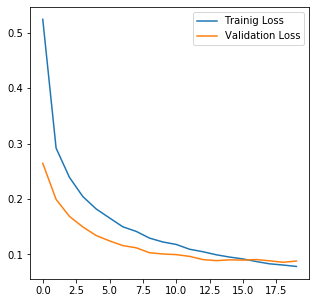

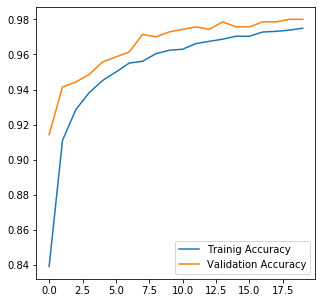

Test Accuracy: 97.7%


In [33]:
layers = [
    Linear(784, 128),
    ReLU(),
    BatchNormalization(128),
    Dropout(.8),
    Linear(128, 10),
    Softmax()]

net = Model(layers, cost=Sparse_Categorical_CrossEntropy())
train(net, preparedData, 20, lr=.01, verbose=1, trend_plot=True)
test(net, preparedData.test)